In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

[*********************100%***********************]  1 of 1 completed


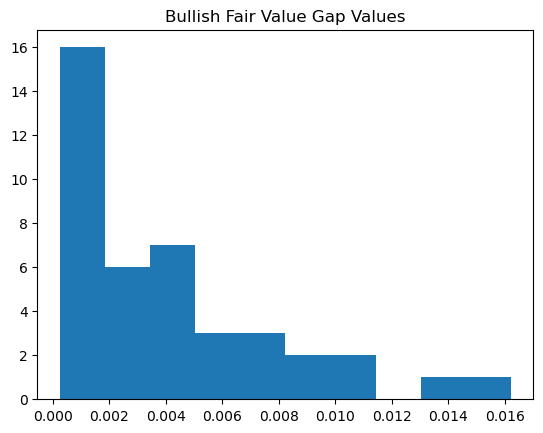

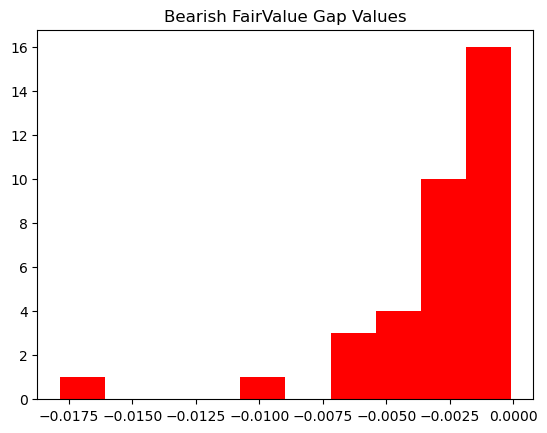

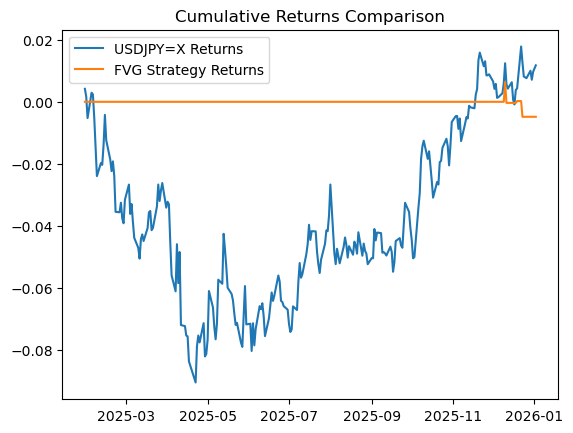

41 trades taken
Bull FVG Average returns: -0.14%
21 Medium sized FVGs
Medium Bull FVG Average returns: -0.48%
35 trades taken
Bear FVG Average returns: -0.42%
17 Medium sized FVGs
Medium Bear FVG Average returns: -0.54%


In [25]:
ticker = 'USDJPY=X'
LOOKBACK = -240
Holding_period = 5

def get_data():
    df = yf.download(ticker, period = '30y', auto_adjust=True, interval='1d')
    df.sort_index(inplace=True)
    df.columns = df.columns.get_level_values(0)

    return df.iloc[LOOKBACK:,:]

def bull_fvg(df):

    df['High_2prev'] = df['High'].shift(2)
    df['Bull_FVG'] = (df['Low'] > df['High_2prev']).astype(int)
    df['Bull_FVG_Val'] = (df['Low'] - df['High_2prev']) * df['Bull_FVG'] / df['Close']

    fvg_subset = df[df['Bull_FVG_Val'] > 0]

    
    plt.hist(fvg_subset['Bull_FVG_Val'], bins=10)
    plt.title("Bullish Fair Value Gap Values")

    return df

def bear_fvg(df):

    df['Low_2prev'] = df['Low'].shift(2)
    df['Bear_FVG'] = (df['High'] < df['Low_2prev']).astype(int)
    df['Bear_FVG_Val'] = (df['High'] - df['Low_2prev']) * df['Bear_FVG'] / df['Close']

    fvg_subset = df[df['Bear_FVG_Val'] < 0]

    plt.figure()
    plt.hist(fvg_subset['Bear_FVG_Val'], bins=10, color='red')
    plt.title("Bearish FairValue Gap Values")

    return df

def strategy(df):
    # 1. Calculate Trend Filter
    df['SMA_200'] = df['Close'].rolling(200).mean()

    # --- BUY SIDE LOGIC ---
    # Calculate thresholds based on the Positive FVGs only
    # We use a temporary series just to get the quantile numbers
    all_bull_fvgs = df[df['Bull_FVG_Val'] > 0]['Bull_FVG_Val']
    lower_b = all_bull_fvgs.quantile(0.25)
    upper_b = all_bull_fvgs.quantile(0.75)

    # Create a "Mask" (True/False) for the whole dataframe
    # Condition: FVG is positive AND it is between the quantile limits
    is_medium_bull = (df['Bull_FVG_Val'] >= lower_b) & (df['Bull_FVG_Val'] <= upper_b)

    # Define Signal using the Mask
    buy_signal = is_medium_bull & (df['Close'] > df['SMA_200'])


    # --- SELL SIDE LOGIC ---
    # Calculate thresholds based on Negative FVGs only
    all_bear_fvgs = df[df['Bear_FVG_Val'] < 0]['Bear_FVG_Val']
    lower_s = all_bear_fvgs.quantile(0.25)
    upper_s = all_bear_fvgs.quantile(0.75)

    # Create Mask
    # Note: You originally had a typo here using 'lower' instead of 'lower_s'
    is_medium_bear = (df['Bear_FVG_Val'] >= lower_s) & (df['Bear_FVG_Val'] <= upper_s)

    # Define Signal
    sell_signal = is_medium_bear & (df['Close'] < df['SMA_200'])


    # --- EXECUTE ---
    conditions = [buy_signal, sell_signal]
    choices = [1, -1]

    df['strategy'] = np.select(conditions, choices, default=0)

    # CRITICAL CHECK
    df['strategy'] = df['strategy'].shift(1)
    
    return df

def test_strategy(df):
    df['Asset_returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['strategy_returns'] = (1 + df['Close'].pct_change() * df['strategy']).cumprod() - 1

    plt.figure()
    plt.plot(df['Asset_returns'], label=f'{ticker} Returns')
    plt.plot(df['strategy_returns'], label='FVG Strategy Returns')
    plt.legend()
    plt.title('Cumulative Returns Comparison')
    plt.show()

    return df

def main():
    df = get_data()
    df = bull_fvg(df)
    df = bear_fvg(df)
    df = strategy(df)
    df = test_strategy(df)

    return df

df = main()
df

def assess_bull_FVG(df, Holding_period):

    df[f'Price_{Holding_period}_Periods'] = df["Close"].shift(-Holding_period) / df['Close']

    fvg_subset = df[df['Bull_FVG_Val'] > 0]
    print(f'{len(fvg_subset)} trades taken')
    print(f'Bull FVG Average returns: {round((fvg_subset[f'Price_{Holding_period}_Periods'].mean()-1) * 100, 2)}%')

    #dfn quantiles
    lower = fvg_subset["Bull_FVG_Val"].quantile(.25)
    upper = fvg_subset["Bull_FVG_Val"].quantile(.75)

    fvg_medium_val = fvg_subset[(fvg_subset["Bull_FVG_Val"] >= lower) & (fvg_subset["Bull_FVG_Val"] <= upper)]
    print(f'{len(fvg_medium_val)} Medium sized FVGs')
    print(f'Medium Bull FVG Average returns: {round((fvg_medium_val[f'Price_{Holding_period}_Periods'].mean()-1) * 100, 2)}%')

    return

def assess_bear_FVG(df, Holding_period):

    df[f'Price_{Holding_period}_Periods'] = df["Close"].shift(-Holding_period) / df['Close']

    fvg_subset = df[df['Bear_FVG_Val'] < 0]
    print(f'{len(fvg_subset)} trades taken')
    print(f'Bear FVG Average returns: {round((fvg_subset[f"Price_{Holding_period}_Periods"].mean()-1) * 100 * -1, 2)}%')

    #dfn quantiles
    lower = fvg_subset["Bear_FVG_Val"].quantile(.25)
    upper = fvg_subset["Bear_FVG_Val"].quantile(.75)

    fvg_medium_val = fvg_subset[(fvg_subset["Bear_FVG_Val"] >= lower) & (fvg_subset["Bear_FVG_Val"] <= upper)]
    print(f'{len(fvg_medium_val)} Medium sized FVGs')
    print(f'Medium Bear FVG Average returns: {round((fvg_medium_val[f'Price_{Holding_period}_Periods'].mean()-1) * 100 *-1, 2)}%')

    return 

assess_bull_FVG(df, Holding_period)
assess_bear_FVG(df, Holding_period)